## Package Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.pandas.set_option('display.max_columns', None) 
sns.set_theme(color_codes = True)

import os
import sys
import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

# ELO
from ELO import ELO

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

# pytorch
import torch
print(torch.cuda.is_available())

# Wandb
import wandb
from wandb.xgboost import WandbCallback
wandb.login(key = '95d4fb2d02fe3866b9b32239df088d24cccd2efe')

# XGBoost
from xgboost import XGBClassifier
from xgboost import plot_importance as xgb_plot_importance

# Optuna
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from optuna.integration import XGBoostPruningCallback

# Seed 고정
SEED = 42
def seed_everything(seed) :
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.use_deterministic_algorithms(True)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
seed_everything(SEED)

True


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jw0112 (teemo-dkt). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /data/ephemeral/.netrc
/data/ephemeral/.cache/pypoetry/virtualenvs/level2-dkt-recsys-05-ywsvzukT-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Preprocessed Data

In [2]:
data = pd.read_parquet('./data/data_preprocessed.parquet')
data

,userID,assessmentItemID,answerCode,KnowledgeTag,testID,testCode,testNum,problemID,problemID_Norm,year,month,day,hour,dow,weekday,ElapsedTime,ElapsedTime_Rolling2,ElapsedTime_Rolling3,ElapsedTime_Rolling4,ElapsedTime_Rolling5,user_ElaspedTime_avg,item_ElaspedTime_avg,testID_ElaspedTime_avg,testCode_ElaspedTime_avg,testNum_ElaspedTime_avg,problemID_ElaspedTime_avg,tag_ElaspedTime_avg,Real_Solved,Correct_User_ElapsedTime,Wrong_User_ElapsedTime,user_sum,user_cnt,user_acc,user_itemID_sum,user_itemID_cnt,user_itemID_acc,user_testID_sum,user_testID_cnt,user_testID_acc,user_testCode_sum,user_testCode_cnt,user_testCode_acc,user_testNum_sum,user_testNum_cnt,user_testNum_acc,user_problemID_sum,user_problemID_cnt,user_problemID_acc,user_tag_sum,user_tag_cnt,user_tag_acc,itemID_sum,itemID_cnt,itemID_acc,testID_sum,testID_cnt,testID_acc,testCode_sum,testCode_cnt,testCode_acc,testNum_sum,testNum_cnt,testNum_acc,problemID_sum,problemID_cnt,problemID_acc,tag_sum,tag_cnt,tag_acc,itemID_high_freq,testID_high_freq,testCode_high_freq,testNum_high_freq,problemID_high_freq,tag_high_freq,user_past_solved,relative_correct_rate,is_correct_before1,correct_rate_before1,relative_correct_rate_before1,is_correct_before2,correct_rate_before2,relative_correct_rate_before2,is_correct_before3,correct_rate_before3,relative_correct_rate_before3,is_correct_before4,correct_rate_before4,relative_correct_rate_before4,is_correct_before5,correct_rate_before5,relative_correct_rate_before5,theta,beta
0,0,A060001001,1,7224,060001,6,1,1,0.000000,2020,3,24,0,1,1,3.000000,0.000000,0.000000,0.000000,0.000000,41.867017,13.660000,26.211300,64.799883,42.032388,63.293682,15.642489,0,13.813008,4.250000,0,0,0.000000,0,0,0.0,0,0,0.00,0,0,0.00,0,0,0.00,0,0,0.0,0,0,0.00,246,250,0.984000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,310634,414350,0.749690,718,750,0.957333,0,0,1,1,1,0,0,0.016000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.0,1.0,0.578202,-3.342176
1,0,A060001002,1,7225,060001,6,1,2,0.083333,2020,3,24,0,1,1,8.000000,5.500000,0.000000,0.000000,0.000000,41.867017,26.112000,26.211300,64.799883,42.032388,63.614356,35.345015,0,24.582645,72.375000,1,1,1.000000,0,0,0.0,1,1,1.00,1,1,1.00,1,1,1.00,0,0,0.0,0,0,0.00,242,250,0.968000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,297842,413500,0.720295,3439,3750,0.917067,0,0,1,1,1,1,0,0.032000,1,0.984000,0.016000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.0,1.0,0.578202,-3.003042
2,0,A060001003,1,7225,060001,6,1,3,0.166667,2020,3,24,0,1,1,7.000000,7.500000,6.000000,0.000000,0.000000,41.867017,19.180000,26.211300,64.799883,42.032388,61.593640,35.345015,0,19.838428,12.000000,2,2,1.000000,0,0,0.0,2,2,1.00,2,2,1.00,2,2,1.00,0,0,0.0,1,1,1.00,229,250,0.916000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,285143,414250,0.688336,3439,3750,0.917067,0,0,1,1,1,1,0,0.084000,1,0.968000,0.032000,1,0.984000,0.016000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.0,1.0,0.578202,-2.298332
3,0,A060001004,1,7225,060001,6,1,4,0.250000,2020,3,24,0,1,1,7.000000,7.000000,7.333333,6.250000,0.000000,41.867017,18.076000,26.211300,64.799883,42.032388,62.033714,35.345015,0,18.440329,5.428571,3,3,1.000000,0,0,0.0,3,3,1.00,3,3,1.00,3,3,1.00,0,0,0.0,2,2,1.00,243,250,0.972000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,273382,412050,0.663468,3439,3750,0.917067,0,0,1,1,1,1,0,0.028000,1,0.916000,0.084000,1,0.968000,0.032000,1,0.984000,0.016000,1,1.000000,1.000000,1,1.0,1.0,0.578202,-3.064188
4,0,A060001005,1,7225,060001,6,1,5,0.333333,2020,3,24,0,1,1,11.000000,9.000000,8.333333,8.250000,7.200000,41.867017,35.720000,26.211300,64.799883,42.032388,60.549753,35.345015,1,36.459916,22.230769,4,4,1.000000,0,0,0.0,4,4,1.00,4,4,1.00,4,4,1.00,0,0,0.0,3,3,1.00,237,250,0.948000,1429,1500,0.952667,210971,296350,0.711898,11867,16750,0.708478,240452,401900,0.598288,3439,3750,0.917067,0,0,1,1,1,1,0,0.052000,1,0.972000,0.028000,1,0.916000,0.084000,1,0.968000

In [3]:
data_dtype = data.dtypes.to_frame().T
data_isnull = data.isnull().sum().to_frame().T
print(f'Row 개수 : {data.shape[0]} / Columns 개수 : {data.shape[1]}')

data_info = pd.concat([data_dtype, data_isnull], axis = 0).set_index(pd.Index(['Dtype', 'Null']))
data_info

Row 개수 : 2526700 / Columns 개수 : 94


,userID,assessmentItemID,answerCode,KnowledgeTag,testID,testCode,testNum,problemID,problemID_Norm,year,month,day,hour,dow,weekday,ElapsedTime,ElapsedTime_Rolling2,ElapsedTime_Rolling3,ElapsedTime_Rolling4,ElapsedTime_Rolling5,user_ElaspedTime_avg,item_ElaspedTime_avg,testID_ElaspedTime_avg,testCode_ElaspedTime_avg,testNum_ElaspedTime_avg,problemID_ElaspedTime_avg,tag_ElaspedTime_avg,Real_Solved,Correct_User_ElapsedTime,Wrong_User_ElapsedTime,user_sum,user_cnt,user_acc,user_itemID_sum,user_itemID_cnt,user_itemID_acc,user_testID_sum,user_testID_cnt,user_testID_acc,user_testCode_sum,user_testCode_cnt,user_testCode_acc,user_testNum_sum,user_testNum_cnt,user_testNum_acc,user_problemID_sum,user_problemID_cnt,user_problemID_acc,user_tag_sum,user_tag_cnt,user_tag_acc,itemID_sum,itemID_cnt,itemID_acc,testID_sum,testID_cnt,testID_acc,testCode_sum,testCode_cnt,testCode_acc,testNum_sum,testNum_cnt,testNum_acc,problemID_sum,problemID_cnt,problemID_acc,tag_sum,tag_cnt,tag_acc,itemID_high_freq,testID_high_freq,testCode_high_freq,testNum_high_freq,problemID_high_freq,tag_high_freq,user_past_solved,relative_correct_rate,is_correct_before1,correct_rate_before1,relative_correct_rate_before1,is_correct_before2,correct_rate_before2,relative_correct_rate_before2,is_correct_before3,correct_rate_before3,relative_correct_rate_before3,is_correct_before4,correct_rate_before4,relative_correct_rate_before4,is_correct_before5,correct_rate_before5,relative_correct_rate_before5,theta,beta
Dtype,int16,object,int8,int16,object,int8,int16,int8,float64,int16,int8,int8,int8,int8,int8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int8,float64,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int16,int16,float64,int32,int32,float64,int32,int32,float64,int32,int32,float64,int32,int32,float64,int32,int32,float64,int32,int32,float64,int8,int8,int8,int8,int8,int8,int8,float64,int8,float64,float64,int8,float64,float64,int8,float64,float64,int8,float64,float64,int8,float64,float64,float64,float64
Null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
use_col = [
    'userID', 'assessmentItemID', 'KnowledgeTag', 'testID',
    'testCode', 'testNum', 'problemID', # 'problemID_Norm'
    
    'year', 'month', 'day', 'hour', 'dow', 'weekday', 'ElapsedTime',
    'ElapsedTime_Rolling2', 'ElapsedTime_Rolling3', 'ElapsedTime_Rolling4', 'ElapsedTime_Rolling5',
    'user_ElaspedTime_avg', 'item_ElaspedTime_avg', 'testID_ElaspedTime_avg', 'testCode_ElaspedTime_avg',
    'testNum_ElaspedTime_avg', 'problemID_ElaspedTime_avg', 'tag_ElaspedTime_avg',
    'Real_Solved', 'Correct_User_ElapsedTime', 'Wrong_User_ElapsedTime',
    
    'user_sum', 'user_cnt', 'user_acc', 'user_itemID_sum', 'user_itemID_cnt', 'user_itemID_acc',
    'user_testID_sum', 'user_testID_cnt', 'user_testID_acc', 'user_testCode_sum', 'user_testCode_cnt', 'user_testCode_acc',
    'user_testNum_sum', 'user_testNum_cnt', 'user_testNum_acc', 'user_problemID_sum', 'user_problemID_cnt', 'user_problemID_acc',
    'user_tag_sum', 'user_tag_cnt', 'user_tag_acc',
    
    'itemID_sum', 'itemID_cnt', 'itemID_acc', 'testID_sum', 'testID_cnt', 'testID_acc',
    'testCode_sum', 'testCode_cnt', 'testCode_acc', 'testNum_sum', 'testNum_cnt', 'testNum_acc',
    'problemID_sum', 'problemID_cnt', 'problemID_acc', 'tag_sum', 'tag_cnt', 'tag_acc',
    'itemID_high_freq', 'testID_high_freq', 'testCode_high_freq',
    'testNum_high_freq', 'problemID_high_freq', 'tag_high_freq',

    'user_past_solved',
    # 'relative_correct_rate',
    'is_correct_before1', 'correct_rate_before1', 'relative_correct_rate_before1',
    'is_correct_before2', 'correct_rate_before2', 'relative_correct_rate_before2',
    'is_correct_before3', 'correct_rate_before3', 'relative_correct_rate_before3',
    'is_correct_before4', 'correct_rate_before4', 'relative_correct_rate_before4',
    'is_correct_before5', 'correct_rate_before5', 'relative_correct_rate_before5',
    
    'theta', 'beta'
]
print(len(use_col))

91


## Data Split

In [ ]:
train_le, test_le = data[data['answerCode'] != -1], data[data['answerCode'] == -1].drop(columns = 'answerCode')
valid_indices = set(data[data['answerCode'] != -1].index).intersection(set(data.reset_index().groupby('userID', as_index = False).last().set_index('index').index))

obj_col = ['assessmentItemID', 'testID']
for col in obj_col :
    le = LabelEncoder()
    train_le[col] = le.fit_transform(train_le[col])
    for label in tqdm.tqdm((test_le[col].unique())) : 
        if label not in le.classes_ : 
            le.classes_ = np.append(le.classes_, label)
    test_le[col] = le.transform(test_le[col])

train_GB = train_le.loc[~train_le.index.isin(valid_indices)]
valid_GB = train_le.loc[train_le.index.isin(valid_indices)]
print(train_GB.shape, valid_GB.shape)

X_train, y_train = train_GB[use_col], train_GB['answerCode']
X_valid, y_valid = valid_GB[use_col], valid_GB['answerCode']
test_GB = test_le[use_col]

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, test_GB.shape)

## XGBoostClassifier

### Optuna HPO

In [10]:
def objective_XGB_CLF(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'booster' : trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'max_depth' : trial.suggest_int('max_depth', 1, 15),
        'learning_rate' : trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.5]),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
        'gamma' : trial.suggest_categorical('alpha', [1e-5, 1e-3, 1, 5, 10]),
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree', [0.1, 0.5, 1]),
        'lambda' : trial.suggest_categorical('lambda', [1e-5, 1e-3, 1, 5, 10]),
        'alpha' : trial.suggest_categorical('alpha', [1e-5, 1e-3, 1, 5, 10]),
        'subsample' : trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'max_delta_step' : trial.suggest_categorical('max_delta_step', [0.1, 0.5, 1, 5, 10]),
    }
    pruning_callback = XGBoostPruningCallback(trial, 'validation_1-' + 'auc')
    model = XGBClassifier(**param, n_estimators = 3000, objective = 'binary:logistic', eval_metric = 'auc',
                          nthread = -1, tree_method = 'hist', device = 'cuda', updater = 'grow_gpu_hist',
                          callbacks = [pruning_callback], # predictor = 'gpu_predictor', 
                          early_stopping_rounds = 100, random_state = SEED)
    xgb_model = model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = 300)
    
    proba = xgb_model.predict_proba(X_valid)
    # score = log_loss(y_valid, proba[:, 1])
    # score = accuracy_score(y_valid, np.where(proba[:, 1] >= 0.5, 1, 0))
    score = roc_auc_score(y_valid, proba[:, 1])
    return score

In [75]:
# Study Optuna
study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objective_XGB_CLF(trial, X_train, y_train, X_valid, y_valid), show_progress_bar = True, n_trials = 100)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

[I 2024-01-12 18:22:37,889] A new study created in memory with name: no-name-be749a42-d1c5-4c3d-8a0b-61c4a8064aab
  0%|          | 0/100 [00:00<?, ?it/s]

[0]	validation_0-auc:0.67252	validation_1-auc:0.62986
[108]	validation_0-auc:0.80724	validation_1-auc:0.77079


Best trial: 0. Best value: 0.771904:   1%|          | 1/100 [00:23<39:31, 23.95s/it]

[I 2024-01-12 18:23:01,842] Trial 0 finished with value: 0.7719036934883421 and parameters: {'booster': 'dart', 'max_depth': 11, 'learning_rate': 0.01, 'min_child_weight': 9, 'alpha': 5, 'colsample_bytree': 0.1, 'lambda': 10, 'subsample': 1.0, 'max_delta_step': 0.1}. Best is trial 0 with value: 0.7719036934883421.
[0]	validation_0-auc:0.62583	validation_1-auc:0.59147
[300]	validation_0-auc:0.81055	validation_1-auc:0.77322
[600]	validation_0-auc:0.82904	validation_1-auc:0.79292
[900]	validation_0-auc:0.83886	validation_1-auc:0.80481
[1200]	validation_0-auc:0.84327	validation_1-auc:0.81025
[1500]	validation_0-auc:0.84588	validation_1-auc:0.81411
[1800]	validation_0-auc:0.84762	validation_1-auc:0.81666
[2100]	validation_0-auc:0.84861	validation_1-auc:0.81805
[2400]	validation_0-auc:0.84939	validation_1-auc:0.81906
[2700]	validation_0-auc:0.84994	validation_1-auc:0.81982
[2999]	validation_0-auc:0.85038	validation_1-auc:0.82041


Best trial: 1. Best value: 0.820413:   2%|▏         | 2/100 [01:17<1:07:46, 41.49s/it]

[I 2024-01-12 18:23:55,607] Trial 1 finished with value: 0.82041332914133 and parameters: {'booster': 'gbtree', 'max_depth': 1, 'learning_rate': 0.05, 'min_child_weight': 1, 'alpha': 1e-05, 'colsample_bytree': 0.1, 'lambda': 10, 'subsample': 0.7, 'max_delta_step': 0.1}. Best is trial 1 with value: 0.82041332914133.
[0]	validation_0-auc:0.76600	validation_1-auc:0.70104
[300]	validation_0-auc:0.90770	validation_1-auc:0.83872
[431]	validation_0-auc:0.91958	validation_1-auc:0.83825


Best trial: 2. Best value: 0.839114:   3%|▎         | 3/100 [01:58<1:06:39, 41.23s/it]

[I 2024-01-12 18:24:36,531] Trial 2 finished with value: 0.8391141594437974 and parameters: {'booster': 'gbtree', 'max_depth': 13, 'learning_rate': 0.1, 'min_child_weight': 9, 'alpha': 0.001, 'colsample_bytree': 0.1, 'lambda': 10, 'subsample': 0.6, 'max_delta_step': 5}. Best is trial 2 with value: 0.8391141594437974.
[0]	validation_0-auc:0.84221	validation_1-auc:0.80545
[300]	validation_0-auc:0.88558	validation_1-auc:0.84663
[600]	validation_0-auc:0.88856	validation_1-auc:0.84716
[900]	validation_0-auc:0.88973	validation_1-auc:0.84755
[1058]	validation_0-auc:0.89013	validation_1-auc:0.84754


Best trial: 3. Best value: 0.847587:   4%|▍         | 4/100 [53:44<33:21:39, 1251.03s/it]

[I 2024-01-12 19:16:22,188] Trial 3 finished with value: 0.8475868887952039 and parameters: {'booster': 'dart', 'max_depth': 12, 'learning_rate': 0.05, 'min_child_weight': 5, 'alpha': 5, 'colsample_bytree': 0.5, 'lambda': 0.001, 'subsample': 0.7, 'max_delta_step': 5}. Best is trial 3 with value: 0.8475868887952039.
[0]	validation_0-auc:0.77039	validation_1-auc:0.71873
[300]	validation_0-auc:0.86944	validation_1-auc:0.84123
[406]	validation_0-auc:0.87165	validation_1-auc:0.84094


Best trial: 3. Best value: 0.847587:   5%|▌         | 5/100 [56:59<22:58:11, 870.44s/it] 

[I 2024-01-12 19:19:37,795] Trial 4 finished with value: 0.8415287890588714 and parameters: {'booster': 'dart', 'max_depth': 5, 'learning_rate': 0.5, 'min_child_weight': 9, 'alpha': 0.001, 'colsample_bytree': 0.5, 'lambda': 5, 'subsample': 0.7, 'max_delta_step': 0.5}. Best is trial 3 with value: 0.8475868887952039.
[0]	validation_0-auc:0.78674	validation_1-auc:0.74490


Best trial: 3. Best value: 0.847587:   6%|▌         | 6/100 [57:07<15:04:09, 577.12s/it]

[I 2024-01-12 19:19:45,525] Trial 5 pruned. Trial was pruned at iteration 1.
[0]	validation_0-auc:0.75636	validation_1-auc:0.70349


Best trial: 3. Best value: 0.847587:   7%|▋         | 7/100 [57:15<10:06:07, 391.05s/it]

[I 2024-01-12 19:19:53,483] Trial 6 pruned. Trial was pruned at iteration 2.


Best trial: 3. Best value: 0.847587:   8%|▊         | 8/100 [57:23<6:52:26, 268.98s/it] 

[I 2024-01-12 19:20:01,100] Trial 7 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.75655	validation_1-auc:0.70466


Best trial: 3. Best value: 0.847587:   9%|▉         | 9/100 [57:30<4:44:06, 187.32s/it]

[I 2024-01-12 19:20:08,876] Trial 8 pruned. Trial was pruned at iteration 1.
[0]	validation_0-auc:0.77317	validation_1-auc:0.71529


Best trial: 3. Best value: 0.847587:  10%|█         | 10/100 [57:38<3:17:51, 131.90s/it]

[I 2024-01-12 19:20:16,678] Trial 9 pruned. Trial was pruned at iteration 1.
[0]	validation_0-auc:0.83126	validation_1-auc:0.79407
[242]	validation_0-auc:0.87671	validation_1-auc:0.83950


Best trial: 3. Best value: 0.847587:  11%|█         | 11/100 [58:56<2:51:06, 115.35s/it]

[I 2024-01-12 19:21:34,501] Trial 10 finished with value: 0.8399787601197579 and parameters: {'booster': 'dart', 'max_depth': 8, 'learning_rate': 0.5, 'min_child_weight': 3, 'alpha': 5, 'colsample_bytree': 0.5, 'lambda': 1, 'subsample': 0.8, 'max_delta_step': 10}. Best is trial 3 with value: 0.8475868887952039.
[0]	validation_0-auc:0.77039	validation_1-auc:0.71873


Best trial: 3. Best value: 0.847587:  12%|█▏        | 12/100 [59:04<2:01:11, 82.63s/it] 

[I 2024-01-12 19:21:42,294] Trial 11 pruned. Trial was pruned at iteration 1.
[0]	validation_0-auc:0.82635	validation_1-auc:0.78500


Best trial: 3. Best value: 0.847587:  13%|█▎        | 13/100 [59:29<1:34:36, 65.25s/it]

[I 2024-01-12 19:22:07,544] Trial 12 pruned. Trial was pruned at iteration 119.
[0]	validation_0-auc:0.77039	validation_1-auc:0.71873


Best trial: 3. Best value: 0.847587:  14%|█▍        | 14/100 [59:37<1:08:36, 47.86s/it]

[I 2024-01-12 19:22:15,162] Trial 13 pruned. Trial was pruned at iteration 1.
[0]	validation_0-auc:0.81823	validation_1-auc:0.77517


Best trial: 3. Best value: 0.847587:  15%|█▌        | 15/100 [59:45<50:52, 35.91s/it]  

[I 2024-01-12 19:22:23,445] Trial 14 pruned. Trial was pruned at iteration 6.
[0]	validation_0-auc:0.82096	validation_1-auc:0.78162


Best trial: 3. Best value: 0.847587:  16%|█▌        | 16/100 [1:00:24<51:37, 36.88s/it]

[I 2024-01-12 19:23:02,566] Trial 15 pruned. Trial was pruned at iteration 151.
[0]	validation_0-auc:0.79051	validation_1-auc:0.74475


Best trial: 3. Best value: 0.847587:  17%|█▋        | 17/100 [1:00:32<38:56, 28.15s/it]

[I 2024-01-12 19:23:10,435] Trial 16 pruned. Trial was pruned at iteration 1.
[0]	validation_0-auc:0.77340	validation_1-auc:0.72038


Best trial: 3. Best value: 0.847587:  18%|█▊        | 18/100 [1:00:40<30:10, 22.08s/it]

[I 2024-01-12 19:23:18,358] Trial 17 pruned. Trial was pruned at iteration 1.
[0]	validation_0-auc:0.84487	validation_1-auc:0.80608
[300]	validation_0-auc:0.90275	validation_1-auc:0.84766
[514]	validation_0-auc:0.90946	validation_1-auc:0.84826


Best trial: 18. Best value: 0.848322:  19%|█▉        | 19/100 [1:01:14<34:47, 25.78s/it]

[I 2024-01-12 19:23:52,762] Trial 18 finished with value: 0.8483222013019028 and parameters: {'booster': 'gbtree', 'max_depth': 12, 'learning_rate': 0.05, 'min_child_weight': 10, 'alpha': 1, 'colsample_bytree': 0.5, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 18 with value: 0.8483222013019028.
[0]	validation_0-auc:0.84539	validation_1-auc:0.80573
[300]	validation_0-auc:0.90874	validation_1-auc:0.84714
[545]	validation_0-auc:0.91714	validation_1-auc:0.84776


Best trial: 18. Best value: 0.848322:  20%|██        | 20/100 [1:01:51<38:47, 29.10s/it]

[I 2024-01-12 19:24:29,592] Trial 19 finished with value: 0.8477575759741048 and parameters: {'booster': 'gbtree', 'max_depth': 12, 'learning_rate': 0.05, 'min_child_weight': 3, 'alpha': 1, 'colsample_bytree': 0.5, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 18 with value: 0.8483222013019028.
[0]	validation_0-auc:0.87215	validation_1-auc:0.81399
[300]	validation_0-auc:0.96289	validation_1-auc:0.84759
[342]	validation_0-auc:0.96289	validation_1-auc:0.84759


Best trial: 18. Best value: 0.848322:  21%|██        | 21/100 [1:02:49<49:37, 37.68s/it]

[I 2024-01-12 19:25:27,303] Trial 20 finished with value: 0.8476524483919143 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.05, 'min_child_weight': 1, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 18 with value: 0.8483222013019028.
[0]	validation_0-auc:0.87116	validation_1-auc:0.81565
[300]	validation_0-auc:0.95656	validation_1-auc:0.84843
[361]	validation_0-auc:0.95656	validation_1-auc:0.84843


Best trial: 21. Best value: 0.848477:  22%|██▏       | 22/100 [1:03:42<54:53, 42.23s/it]

[I 2024-01-12 19:26:20,127] Trial 21 finished with value: 0.8484771238093877 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 21 with value: 0.8484771238093877.
[0]	validation_0-auc:0.85579	validation_1-auc:0.81933
[300]	validation_0-auc:0.90798	validation_1-auc:0.84841
[473]	validation_0-auc:0.91322	validation_1-auc:0.84848


Best trial: 22. Best value: 0.848483:  23%|██▎       | 23/100 [1:04:14<50:29, 39.34s/it]

[I 2024-01-12 19:26:52,737] Trial 22 finished with value: 0.8484826168818642 and parameters: {'booster': 'gbtree', 'max_depth': 12, 'learning_rate': 0.05, 'min_child_weight': 3, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 22 with value: 0.8484826168818642.
[0]	validation_0-auc:0.87116	validation_1-auc:0.81565
[300]	validation_0-auc:0.95656	validation_1-auc:0.84843
[361]	validation_0-auc:0.95656	validation_1-auc:0.84843


Best trial: 22. Best value: 0.848483:  24%|██▍       | 24/100 [1:05:07<55:01, 43.44s/it]

[I 2024-01-12 19:27:45,723] Trial 23 finished with value: 0.8484771238093877 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 22 with value: 0.8484826168818642.
[0]	validation_0-auc:0.87116	validation_1-auc:0.81565
[300]	validation_0-auc:0.95656	validation_1-auc:0.84843
[361]	validation_0-auc:0.95656	validation_1-auc:0.84843


Best trial: 22. Best value: 0.848483:  25%|██▌       | 25/100 [1:06:00<57:49, 46.26s/it]

[I 2024-01-12 19:28:38,576] Trial 24 finished with value: 0.8484771238093877 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 22 with value: 0.8484826168818642.
[0]	validation_0-auc:0.87116	validation_1-auc:0.81565
[300]	validation_0-auc:0.95656	validation_1-auc:0.84843
[362]	validation_0-auc:0.95656	validation_1-auc:0.84843


Best trial: 22. Best value: 0.848483:  26%|██▌       | 26/100 [1:06:53<59:30, 48.25s/it]

[I 2024-01-12 19:29:31,471] Trial 25 finished with value: 0.8484771238093877 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 22 with value: 0.8484826168818642.
[0]	validation_0-auc:0.83424	validation_1-auc:0.78109


Best trial: 22. Best value: 0.848483:  27%|██▋       | 27/100 [1:07:01<43:59, 36.15s/it]

[I 2024-01-12 19:29:39,396] Trial 26 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.86047	validation_1-auc:0.81733
[300]	validation_0-auc:0.92804	validation_1-auc:0.84867
[414]	validation_0-auc:0.92937	validation_1-auc:0.84881


Best trial: 27. Best value: 0.848818:  28%|██▊       | 28/100 [1:07:39<44:04, 36.73s/it]

[I 2024-01-12 19:30:17,465] Trial 27 finished with value: 0.848818364189812 and parameters: {'booster': 'gbtree', 'max_depth': 13, 'learning_rate': 0.05, 'min_child_weight': 1, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 27 with value: 0.848818364189812.
[0]	validation_0-auc:0.85211	validation_1-auc:0.81678


Best trial: 27. Best value: 0.848818:  28%|██▊       | 28/100 [1:07:47<44:04, 36.73s/it]

[I 2024-01-12 19:30:25,551] Trial 28 pruned. Trial was pruned at iteration 3.


Best trial: 27. Best value: 0.848818:  29%|██▉       | 29/100 [1:07:47<33:17, 28.14s/it]

[0]	validation_0-auc:0.85035	validation_1-auc:0.81632


Best trial: 27. Best value: 0.848818:  30%|███       | 30/100 [1:07:55<25:42, 22.03s/it]

[I 2024-01-12 19:30:33,344] Trial 29 pruned. Trial was pruned at iteration 1.
[0]	validation_0-auc:0.86079	validation_1-auc:0.81711


Best trial: 27. Best value: 0.848818:  31%|███       | 31/100 [1:08:24<27:54, 24.27s/it]

[I 2024-01-12 19:31:02,835] Trial 30 pruned. Trial was pruned at iteration 242.
[0]	validation_0-auc:0.87116	validation_1-auc:0.81565
[300]	validation_0-auc:0.95656	validation_1-auc:0.84843
[361]	validation_0-auc:0.95656	validation_1-auc:0.84843


Best trial: 27. Best value: 0.848818:  32%|███▏      | 32/100 [1:09:18<37:25, 33.02s/it]

[I 2024-01-12 19:31:56,287] Trial 31 finished with value: 0.8484771238093877 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 27 with value: 0.848818364189812.
[0]	validation_0-auc:0.86467	validation_1-auc:0.81667


Best trial: 27. Best value: 0.848818:  33%|███▎      | 33/100 [1:09:47<35:25, 31.73s/it]

[I 2024-01-12 19:32:24,984] Trial 32 pruned. Trial was pruned at iteration 145.
[0]	validation_0-auc:0.85644	validation_1-auc:0.81646


Best trial: 27. Best value: 0.848818:  34%|███▍      | 34/100 [1:09:55<27:08, 24.67s/it]

[I 2024-01-12 19:32:33,193] Trial 33 pruned. Trial was pruned at iteration 3.
[0]	validation_0-auc:0.75163	validation_1-auc:0.70246


Best trial: 27. Best value: 0.848818:  35%|███▌      | 35/100 [1:10:03<21:16, 19.65s/it]

[I 2024-01-12 19:32:41,114] Trial 34 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.85906	validation_1-auc:0.80807


Best trial: 27. Best value: 0.848818:  36%|███▌      | 36/100 [1:10:11<17:17, 16.21s/it]

[I 2024-01-12 19:32:49,175] Trial 35 pruned. Trial was pruned at iteration 0.


Best trial: 27. Best value: 0.848818:  37%|███▋      | 37/100 [1:10:19<14:24, 13.72s/it]

[I 2024-01-12 19:32:57,219] Trial 36 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.86021	validation_1-auc:0.81864
[300]	validation_0-auc:0.92576	validation_1-auc:0.84908
[432]	validation_0-auc:0.92856	validation_1-auc:0.84950


Best trial: 37. Best value: 0.849504:  38%|███▊      | 38/100 [1:10:57<21:38, 20.95s/it]

[I 2024-01-12 19:33:35,035] Trial 37 finished with value: 0.8495037031347134 and parameters: {'booster': 'gbtree', 'max_depth': 13, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 37 with value: 0.8495037031347134.
[0]	validation_0-auc:0.82818	validation_1-auc:0.77828


Best trial: 37. Best value: 0.849504:  39%|███▉      | 39/100 [1:11:04<17:14, 16.96s/it]

[I 2024-01-12 19:33:42,702] Trial 38 pruned. Trial was pruned at iteration 0.


Best trial: 37. Best value: 0.849504:  40%|████      | 40/100 [1:11:12<14:15, 14.25s/it]

[I 2024-01-12 19:33:50,503] Trial 39 pruned. Trial was pruned at iteration 0.


Best trial: 37. Best value: 0.849504:  41%|████      | 41/100 [1:11:20<12:11, 12.40s/it]

[I 2024-01-12 19:33:58,710] Trial 40 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.86523	validation_1-auc:0.81724


Best trial: 37. Best value: 0.849504:  42%|████▏     | 42/100 [1:11:49<16:49, 17.40s/it]

[I 2024-01-12 19:34:27,762] Trial 41 pruned. Trial was pruned at iteration 135.
[0]	validation_0-auc:0.87016	validation_1-auc:0.81505


Best trial: 37. Best value: 0.849504:  43%|████▎     | 43/100 [1:12:01<14:58, 15.76s/it]

[I 2024-01-12 19:34:39,712] Trial 42 pruned. Trial was pruned at iteration 1.
[0]	validation_0-auc:0.86523	validation_1-auc:0.81724


Best trial: 37. Best value: 0.849504:  44%|████▍     | 44/100 [1:12:35<19:43, 21.13s/it]

[I 2024-01-12 19:35:13,203] Trial 43 pruned. Trial was pruned at iteration 135.


Best trial: 37. Best value: 0.849504:  45%|████▌     | 45/100 [1:12:46<16:40, 18.18s/it]

[I 2024-01-12 19:35:24,670] Trial 44 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.76542	validation_1-auc:0.70400


Best trial: 37. Best value: 0.849504:  46%|████▌     | 46/100 [1:12:58<14:30, 16.12s/it]

[I 2024-01-12 19:35:35,968] Trial 45 pruned. Trial was pruned at iteration 0.


Best trial: 37. Best value: 0.849504:  47%|████▋     | 47/100 [1:13:10<13:10, 14.91s/it]

[I 2024-01-12 19:35:48,071] Trial 46 pruned. Trial was pruned at iteration 0.


Best trial: 37. Best value: 0.849504:  48%|████▊     | 48/100 [1:13:21<12:00, 13.85s/it]

[I 2024-01-12 19:35:59,448] Trial 47 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.85995	validation_1-auc:0.81703
[202]	validation_0-auc:0.93298	validation_1-auc:0.84712


Best trial: 37. Best value: 0.849504:  49%|████▉     | 49/100 [1:13:50<15:36, 18.35s/it]

[I 2024-01-12 19:36:28,308] Trial 48 finished with value: 0.8473217029060586 and parameters: {'booster': 'gbtree', 'max_depth': 13, 'learning_rate': 0.1, 'min_child_weight': 4, 'alpha': 0.001, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 37 with value: 0.8495037031347134.


Best trial: 37. Best value: 0.849504:  50%|█████     | 50/100 [1:14:02<13:44, 16.48s/it]

[I 2024-01-12 19:36:40,411] Trial 49 pruned. Trial was pruned at iteration 0.


Best trial: 37. Best value: 0.849504:  51%|█████     | 51/100 [1:14:14<12:14, 15.00s/it]

[I 2024-01-12 19:36:51,945] Trial 50 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.87116	validation_1-auc:0.81565
[300]	validation_0-auc:0.95656	validation_1-auc:0.84843
[362]	validation_0-auc:0.95656	validation_1-auc:0.84843


Best trial: 37. Best value: 0.849504:  52%|█████▏    | 52/100 [1:15:14<22:52, 28.59s/it]

[I 2024-01-12 19:37:52,270] Trial 51 finished with value: 0.8484771238093877 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 37 with value: 0.8495037031347134.
[0]	validation_0-auc:0.86523	validation_1-auc:0.81724


Best trial: 37. Best value: 0.849504:  53%|█████▎    | 53/100 [1:15:45<22:55, 29.27s/it]

[I 2024-01-12 19:38:23,120] Trial 52 pruned. Trial was pruned at iteration 101.


Best trial: 37. Best value: 0.849504:  54%|█████▍    | 54/100 [1:15:57<18:26, 24.05s/it]

[I 2024-01-12 19:38:34,971] Trial 53 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.86467	validation_1-auc:0.81667


Best trial: 37. Best value: 0.849504:  55%|█████▌    | 55/100 [1:16:26<19:20, 25.79s/it]

[I 2024-01-12 19:39:04,824] Trial 54 pruned. Trial was pruned at iteration 102.
[0]	validation_0-auc:0.83222	validation_1-auc:0.77631


Best trial: 37. Best value: 0.849504:  56%|█████▌    | 56/100 [1:16:39<15:55, 21.71s/it]

[I 2024-01-12 19:39:17,017] Trial 55 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.87188	validation_1-auc:0.81226


Best trial: 37. Best value: 0.849504:  57%|█████▋    | 57/100 [1:16:50<13:24, 18.71s/it]

[I 2024-01-12 19:39:28,729] Trial 56 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.85552	validation_1-auc:0.81927


Best trial: 37. Best value: 0.849504:  58%|█████▊    | 58/100 [1:17:02<11:38, 16.63s/it]

[I 2024-01-12 19:39:40,495] Trial 57 pruned. Trial was pruned at iteration 1.


Best trial: 37. Best value: 0.849504:  59%|█████▉    | 59/100 [1:17:13<10:11, 14.92s/it]

[I 2024-01-12 19:39:51,441] Trial 58 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.85993	validation_1-auc:0.81817


Best trial: 37. Best value: 0.849504:  60%|██████    | 60/100 [1:17:25<09:25, 14.14s/it]

[I 2024-01-12 19:40:03,772] Trial 59 pruned. Trial was pruned at iteration 1.


Best trial: 37. Best value: 0.849504:  61%|██████    | 61/100 [1:17:37<08:45, 13.48s/it]

[I 2024-01-12 19:40:15,673] Trial 60 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.87116	validation_1-auc:0.81565
[300]	validation_0-auc:0.95656	validation_1-auc:0.84843
[361]	validation_0-auc:0.95656	validation_1-auc:0.84843


Best trial: 37. Best value: 0.849504:  62%|██████▏   | 62/100 [1:18:36<17:12, 27.17s/it]

[I 2024-01-12 19:41:14,806] Trial 61 finished with value: 0.8484771238093877 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 37 with value: 0.8495037031347134.
[0]	validation_0-auc:0.87116	validation_1-auc:0.81565
[300]	validation_0-auc:0.95656	validation_1-auc:0.84843
[361]	validation_0-auc:0.95656	validation_1-auc:0.84843


Best trial: 37. Best value: 0.849504:  63%|██████▎   | 63/100 [1:19:36<22:49, 37.01s/it]

[I 2024-01-12 19:42:14,779] Trial 62 finished with value: 0.8484771238093877 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 37 with value: 0.8495037031347134.


Best trial: 37. Best value: 0.849504:  64%|██████▍   | 64/100 [1:19:48<17:38, 29.41s/it]

[I 2024-01-12 19:42:26,455] Trial 63 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.86523	validation_1-auc:0.81724


Best trial: 37. Best value: 0.849504:  65%|██████▌   | 65/100 [1:20:01<14:16, 24.48s/it]

[I 2024-01-12 19:42:39,450] Trial 64 pruned. Trial was pruned at iteration 3.


Best trial: 37. Best value: 0.849504:  66%|██████▌   | 66/100 [1:20:13<11:43, 20.70s/it]

[I 2024-01-12 19:42:51,302] Trial 65 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.75985	validation_1-auc:0.69924


Best trial: 37. Best value: 0.849504:  67%|██████▋   | 67/100 [1:20:25<09:54, 18.01s/it]

[I 2024-01-12 19:43:03,047] Trial 66 pruned. Trial was pruned at iteration 0.


Best trial: 37. Best value: 0.849504:  68%|██████▊   | 68/100 [1:20:36<08:32, 16.00s/it]

[I 2024-01-12 19:43:14,359] Trial 67 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.84840	validation_1-auc:0.81389


Best trial: 37. Best value: 0.849504:  69%|██████▉   | 69/100 [1:20:48<07:35, 14.70s/it]

[I 2024-01-12 19:43:26,019] Trial 68 pruned. Trial was pruned at iteration 0.


Best trial: 37. Best value: 0.849504:  70%|███████   | 70/100 [1:21:00<06:58, 13.93s/it]

[I 2024-01-12 19:43:37,982] Trial 69 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.80735	validation_1-auc:0.76472


Best trial: 37. Best value: 0.849504:  71%|███████   | 71/100 [1:21:11<06:22, 13.19s/it]

[I 2024-01-12 19:43:49,641] Trial 70 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.87116	validation_1-auc:0.81565
[300]	validation_0-auc:0.95656	validation_1-auc:0.84843
[361]	validation_0-auc:0.95656	validation_1-auc:0.84843


Best trial: 37. Best value: 0.849504:  72%|███████▏  | 72/100 [1:22:11<12:38, 27.08s/it]

[I 2024-01-12 19:44:49,116] Trial 71 finished with value: 0.8484771238093877 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 37 with value: 0.8495037031347134.
[0]	validation_0-auc:0.87116	validation_1-auc:0.81565
[300]	validation_0-auc:0.95656	validation_1-auc:0.84843
[362]	validation_0-auc:0.95656	validation_1-auc:0.84843


Best trial: 37. Best value: 0.849504:  73%|███████▎  | 73/100 [1:23:10<16:34, 36.83s/it]

[I 2024-01-12 19:45:48,694] Trial 72 finished with value: 0.8484771238093877 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 37 with value: 0.8495037031347134.
[0]	validation_0-auc:0.86291	validation_1-auc:0.81778


Best trial: 37. Best value: 0.849504:  74%|███████▍  | 74/100 [1:23:25<13:06, 30.24s/it]

[I 2024-01-12 19:46:03,550] Trial 73 pruned. Trial was pruned at iteration 16.
[0]	validation_0-auc:0.87116	validation_1-auc:0.81565
[300]	validation_0-auc:0.95656	validation_1-auc:0.84843
[361]	validation_0-auc:0.95656	validation_1-auc:0.84843


Best trial: 37. Best value: 0.849504:  75%|███████▌  | 75/100 [1:24:25<16:15, 39.02s/it]

[I 2024-01-12 19:47:03,072] Trial 74 finished with value: 0.8484771238093877 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 37 with value: 0.8495037031347134.
[0]	validation_0-auc:0.85923	validation_1-auc:0.81828


Best trial: 37. Best value: 0.849504:  76%|███████▌  | 76/100 [1:24:37<12:26, 31.11s/it]

[I 2024-01-12 19:47:15,723] Trial 75 pruned. Trial was pruned at iteration 3.


Best trial: 37. Best value: 0.849504:  77%|███████▋  | 77/100 [1:24:49<09:40, 25.22s/it]

[I 2024-01-12 19:47:27,212] Trial 76 pruned. Trial was pruned at iteration 0.


Best trial: 37. Best value: 0.849504:  78%|███████▊  | 78/100 [1:25:01<07:47, 21.26s/it]

[I 2024-01-12 19:47:39,219] Trial 77 pruned. Trial was pruned at iteration 0.


Best trial: 37. Best value: 0.849504:  79%|███████▉  | 79/100 [1:25:13<06:27, 18.47s/it]

[I 2024-01-12 19:47:51,187] Trial 78 pruned. Trial was pruned at iteration 0.


Best trial: 37. Best value: 0.849504:  80%|████████  | 80/100 [1:25:25<05:28, 16.45s/it]

[I 2024-01-12 19:48:02,905] Trial 79 pruned. Trial was pruned at iteration 0.


Best trial: 37. Best value: 0.849504:  81%|████████  | 81/100 [1:25:37<04:47, 15.13s/it]

[I 2024-01-12 19:48:14,813] Trial 80 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.87116	validation_1-auc:0.81565
[300]	validation_0-auc:0.95656	validation_1-auc:0.84843
[361]	validation_0-auc:0.95656	validation_1-auc:0.84843


Best trial: 37. Best value: 0.849504:  82%|████████▏ | 82/100 [1:26:37<08:34, 28.61s/it]

[I 2024-01-12 19:49:15,019] Trial 81 finished with value: 0.8484771238093877 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 37 with value: 0.8495037031347134.
[0]	validation_0-auc:0.86523	validation_1-auc:0.81724


Best trial: 37. Best value: 0.849504:  83%|████████▎ | 83/100 [1:26:49<06:44, 23.79s/it]

[I 2024-01-12 19:49:27,574] Trial 82 pruned. Trial was pruned at iteration 3.
[0]	validation_0-auc:0.87116	validation_1-auc:0.81565
[300]	validation_0-auc:0.95656	validation_1-auc:0.84843
[362]	validation_0-auc:0.95656	validation_1-auc:0.84843


Best trial: 37. Best value: 0.849504:  84%|████████▍ | 84/100 [1:27:49<09:14, 34.68s/it]

[I 2024-01-12 19:50:27,649] Trial 83 finished with value: 0.8484771238093877 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 37 with value: 0.8495037031347134.
[0]	validation_0-auc:0.86578	validation_1-auc:0.81724


Best trial: 37. Best value: 0.849504:  85%|████████▌ | 85/100 [1:28:03<07:05, 28.35s/it]

[I 2024-01-12 19:50:41,222] Trial 84 pruned. Trial was pruned at iteration 3.
[0]	validation_0-auc:0.83265	validation_1-auc:0.76712


Best trial: 37. Best value: 0.849504:  86%|████████▌ | 86/100 [1:28:14<05:26, 23.32s/it]

[I 2024-01-12 19:50:52,839] Trial 85 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.86467	validation_1-auc:0.81667


Best trial: 37. Best value: 0.849504:  87%|████████▋ | 87/100 [1:28:27<04:22, 20.21s/it]

[I 2024-01-12 19:51:05,768] Trial 86 pruned. Trial was pruned at iteration 3.
[0]	validation_0-auc:0.86489	validation_1-auc:0.81074


Best trial: 37. Best value: 0.849504:  88%|████████▊ | 88/100 [1:28:39<03:32, 17.68s/it]

[I 2024-01-12 19:51:17,544] Trial 87 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.85578	validation_1-auc:0.81813


Best trial: 37. Best value: 0.849504:  89%|████████▉ | 89/100 [1:28:52<02:56, 16.08s/it]

[I 2024-01-12 19:51:29,878] Trial 88 pruned. Trial was pruned at iteration 1.
[0]	validation_0-auc:0.86048	validation_1-auc:0.81730


Best trial: 37. Best value: 0.849504:  90%|█████████ | 90/100 [1:29:04<02:30, 15.01s/it]

[I 2024-01-12 19:51:42,393] Trial 89 pruned. Trial was pruned at iteration 4.
[0]	validation_0-auc:0.85424	validation_1-auc:0.80495


Best trial: 37. Best value: 0.849504:  90%|█████████ | 90/100 [1:29:16<02:30, 15.01s/it]

[I 2024-01-12 19:51:54,735] Trial 90 pruned. Trial was pruned at iteration 0.


Best trial: 37. Best value: 0.849504:  91%|█████████ | 91/100 [1:29:17<02:08, 14.27s/it]

[0]	validation_0-auc:0.87116	validation_1-auc:0.81565
[300]	validation_0-auc:0.95656	validation_1-auc:0.84843
[362]	validation_0-auc:0.95656	validation_1-auc:0.84843


Best trial: 37. Best value: 0.849504:  92%|█████████▏| 92/100 [1:30:16<03:42, 27.85s/it]

[I 2024-01-12 19:52:54,495] Trial 91 finished with value: 0.8484771238093877 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 37 with value: 0.8495037031347134.
[0]	validation_0-auc:0.87116	validation_1-auc:0.81565
[300]	validation_0-auc:0.95656	validation_1-auc:0.84843
[362]	validation_0-auc:0.95656	validation_1-auc:0.84843


Best trial: 37. Best value: 0.849504:  93%|█████████▎| 93/100 [1:31:16<04:22, 37.53s/it]

[I 2024-01-12 19:53:54,590] Trial 92 finished with value: 0.8484771238093877 and parameters: {'booster': 'gbtree', 'max_depth': 15, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5}. Best is trial 37 with value: 0.8495037031347134.


Best trial: 37. Best value: 0.849504:  94%|█████████▍| 94/100 [1:31:28<02:59, 29.94s/it]

[I 2024-01-12 19:54:06,810] Trial 93 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.87215	validation_1-auc:0.81399


Best trial: 37. Best value: 0.849504:  95%|█████████▌| 95/100 [1:31:41<02:03, 24.65s/it]

[I 2024-01-12 19:54:19,120] Trial 94 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.86116	validation_1-auc:0.81650


Best trial: 37. Best value: 0.849504:  96%|█████████▌| 96/100 [1:31:53<01:24, 21.03s/it]

[I 2024-01-12 19:54:31,689] Trial 95 pruned. Trial was pruned at iteration 2.
[0]	validation_0-auc:0.86057	validation_1-auc:0.82060


Best trial: 37. Best value: 0.849504:  97%|█████████▋| 97/100 [1:32:05<00:55, 18.34s/it]

[I 2024-01-12 19:54:43,769] Trial 96 pruned. Trial was pruned at iteration 3.


Best trial: 37. Best value: 0.849504:  98%|█████████▊| 98/100 [1:32:17<00:32, 16.45s/it]

[I 2024-01-12 19:54:55,803] Trial 97 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.85877	validation_1-auc:0.80832


Best trial: 37. Best value: 0.849504:  99%|█████████▉| 99/100 [1:32:30<00:15, 15.21s/it]

[I 2024-01-12 19:55:08,137] Trial 98 pruned. Trial was pruned at iteration 0.
[0]	validation_0-auc:0.86021	validation_1-auc:0.81864


Best trial: 37. Best value: 0.849504: 100%|██████████| 100/100 [1:32:42<00:00, 55.63s/it]

[I 2024-01-12 19:55:20,798] Trial 99 pruned. Trial was pruned at iteration 3.
Best trial : score 0.8495037031347134, 
 params = {'booster': 'gbtree', 'max_depth': 13, 'learning_rate': 0.05, 'min_child_weight': 2, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 1.0, 'max_delta_step': 5} 



- Best trial : score 0.8381156953162443 
    - params = {'booster': 'gbtree', 'max_depth': 5, 'learning_rate': 0.5, 'min_child_weight': 8, 'alpha': 1, 'colsample_bytree': 0.1, 'lambda': 0.001, 'subsample': 0.8, 'max_delta_step': 0.1}

- Best trial : score 0.8672109047626494, 
    - params = {'booster': 'dart', 'max_depth': 11, 'learning_rate': 0.5, 'min_child_weight': 8, 'alpha': 1, 'colsample_bytree': 1, 'lambda': 5, 'subsample': 1.0, 'max_delta_step': 10} 

### Train

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


[0]	validation_0-auc:0.86031	validation_1-auc:0.81832
[100]	validation_0-auc:0.89918	validation_1-auc:0.84449
[200]	validation_0-auc:0.91501	validation_1-auc:0.84839
[300]	validation_0-auc:0.92594	validation_1-auc:0.84885
[400]	validation_0-auc:0.93489	validation_1-auc:0.84929
[500]	validation_0-auc:0.94311	validation_1-auc:0.84952
[539]	validation_0-auc:0.94576	validation_1-auc:0.84963
ROC-AUC Score : 0.8497 / Accuracy : 0.7702 / Logloss : 0.4791


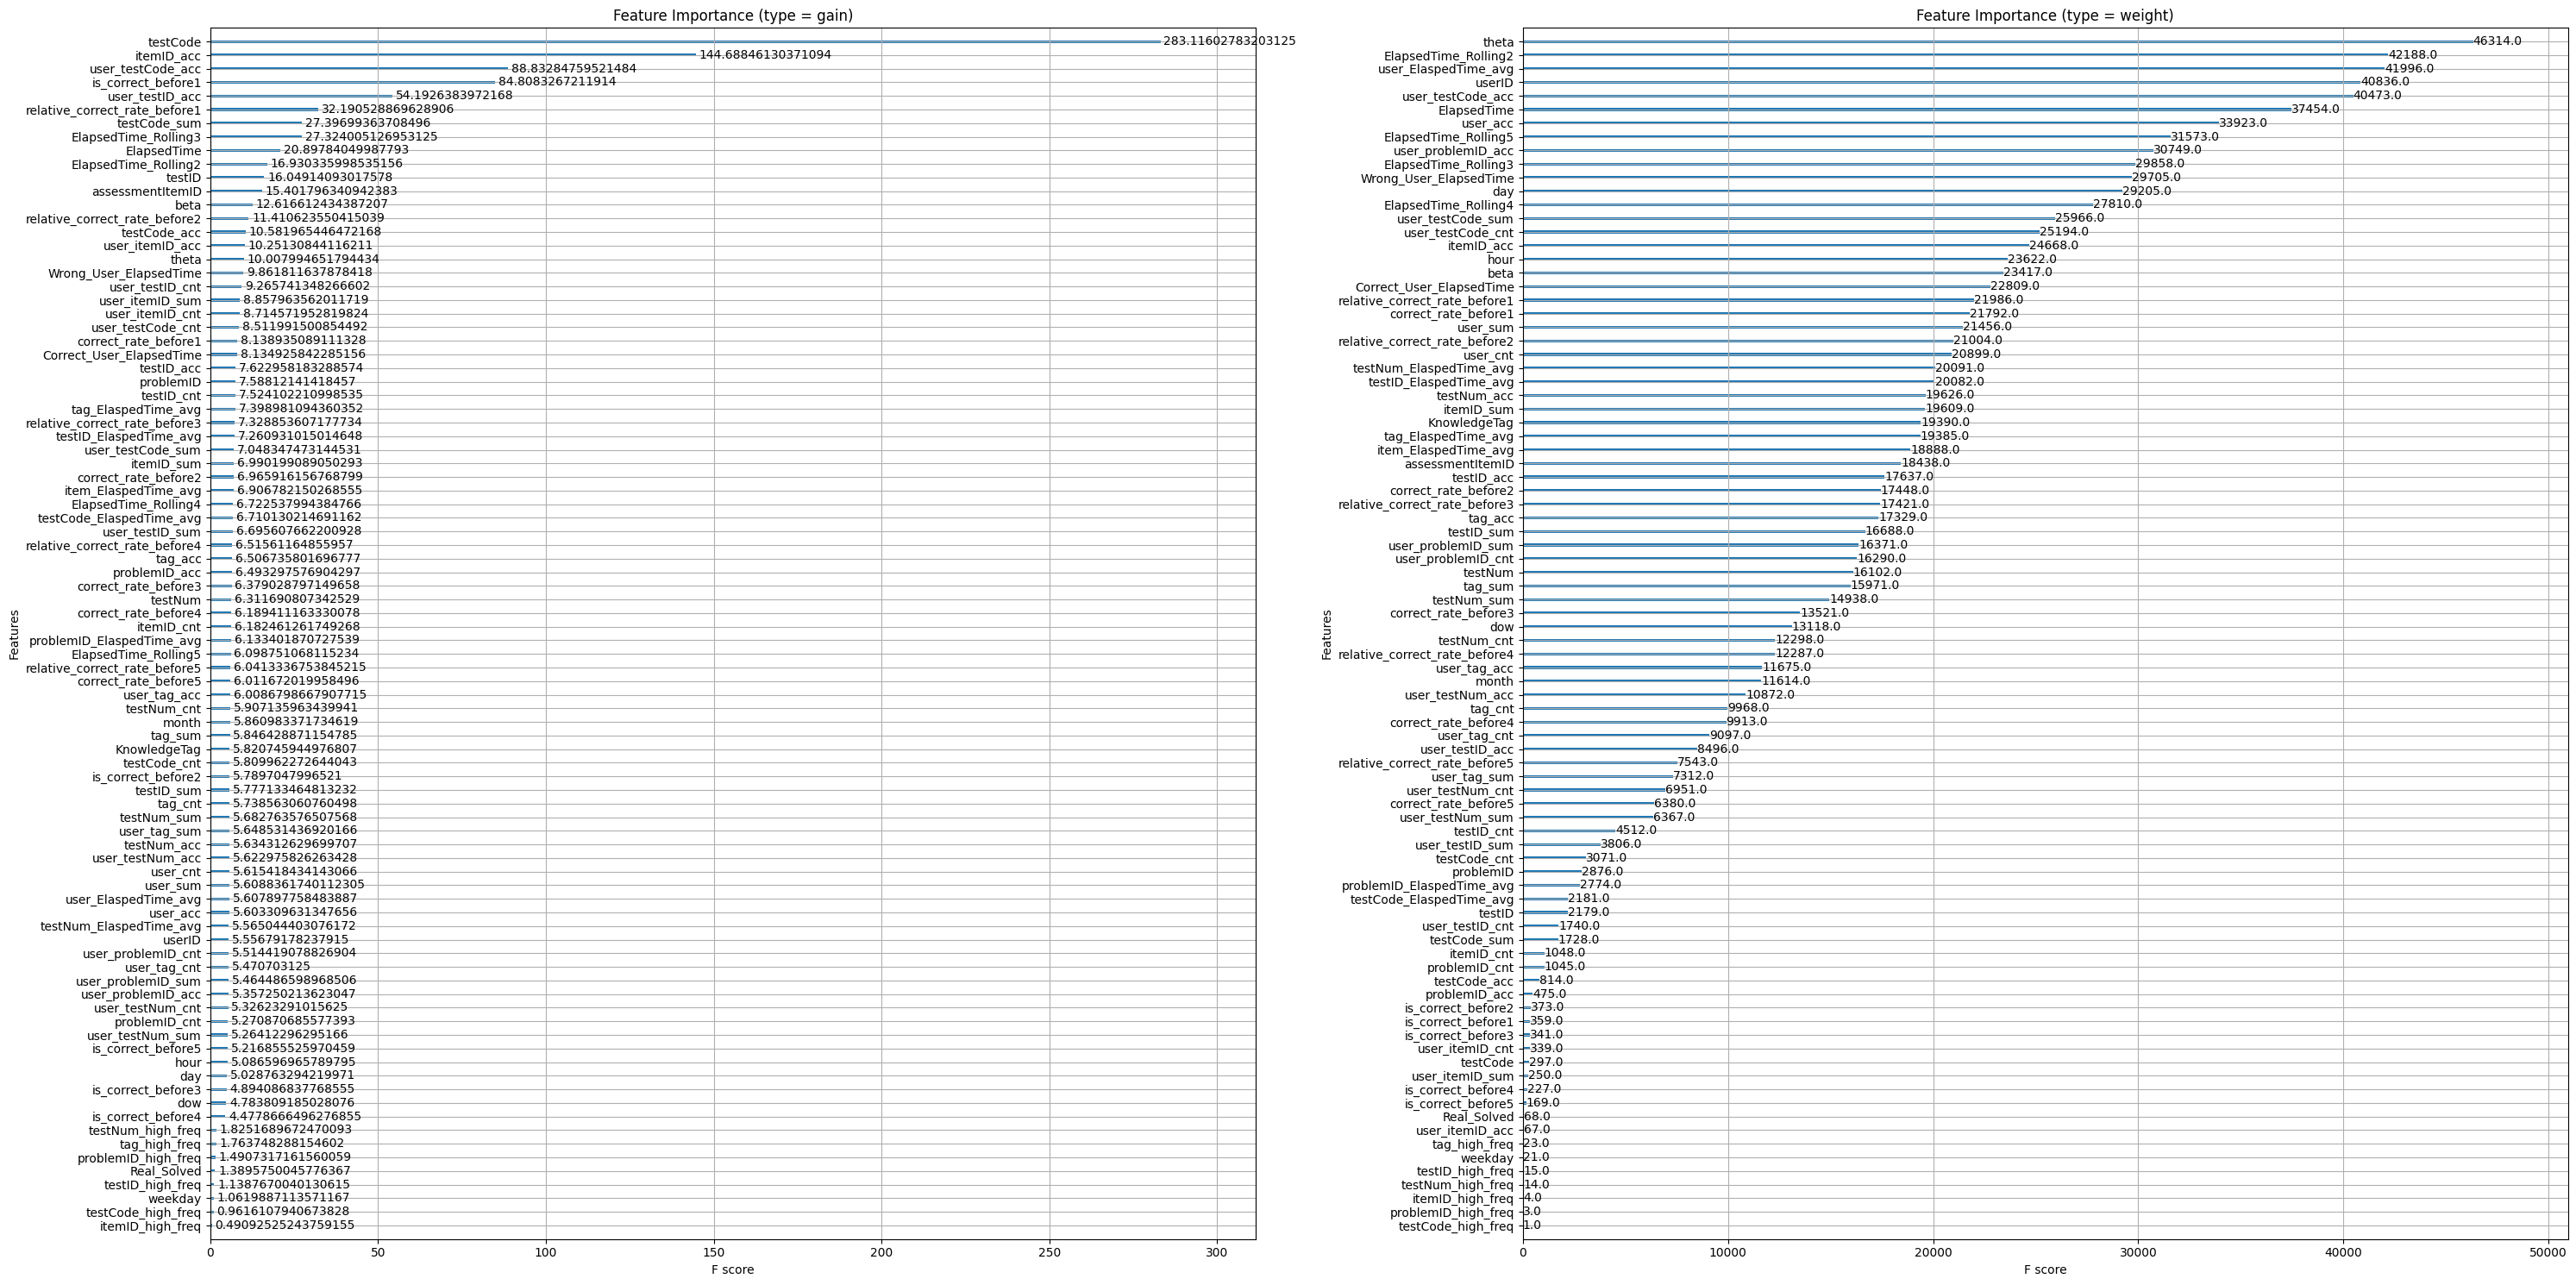

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


best_iteration,▁
best_score,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_0-auc,▁▁▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
validation_1-auc,▁▂▃▄▄▅▆▆▆▇▇▇▇▇▇▇████████████████████████
best_iteration,439
best_score,0.84974
epoch,538


In [76]:
param = study.best_params
# param = {'booster': 'dart', 'max_depth': 11, 'learning_rate': 0.1, 'min_child_weight': 8, 'alpha': 0.001, 'colsample_bytree': 0.5, 'lambda': 10, 'subsample': 0.7, 'max_delta_step': 0.5}
# param = {'booster': 'dart', 'max_depth': 11, 'learning_rate': 0.01, 'min_child_weight': 8, 'alpha': 0.001, 'colsample_bytree': 0.5, 'lambda': 10, 'subsample': 0.7, 'max_delta_step': 0.5} ## Best

wandb.init(project = 'dkt-ljw')
wandb.run.name = 'XGBoost_0112'
wandb.run.save()

xgb_clf = XGBClassifier(**param, n_estimators = 3000, objective = 'binary:logistic', eval_metric = 'auc',
                        nthread = -1, device = 'cuda', tree_method = 'gpu_hist', predictor = 'gpu_predictor', 
                        early_stopping_rounds = 100, random_state = SEED)
xgb_clf.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = 100,
            callbacks = [WandbCallback(log_model = True, log_feature_importance = True, importance_type = 'weight')])

# 모델 지표 출력
proba = xgb_clf.predict_proba(X_valid)
roc_auc = roc_auc_score(y_valid, proba[:, 1])
accuracy = accuracy_score(y_valid, np.where(proba[:, 1] >= 0.5, 1, 0))
logloss = log_loss(y_valid, proba[:, 1])
print(f'ROC-AUC Score : {roc_auc:.4f} / Accuracy : {accuracy:.4f} / Logloss : {logloss:.4f}')

# Feature Importance 출력
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 15))
xgb_plot_importance(xgb_clf, ax = axes[0], importance_type = 'gain')
axes[0].set_title('Feature Importance (type = gain)')
xgb_plot_importance(xgb_clf, ax = axes[1], importance_type = 'weight')
axes[1].set_title('Feature Importance (type = weight)')
plt.tight_layout() ; plt.show()
wandb.finish()

In [81]:
# xgb_clf.save_model('./model/XGB_Feature91.model')
xgb_clf.save_model('./model/XGB_Feature91_NewHPO.model')

361 / 744
0.0006210166 0.9933422


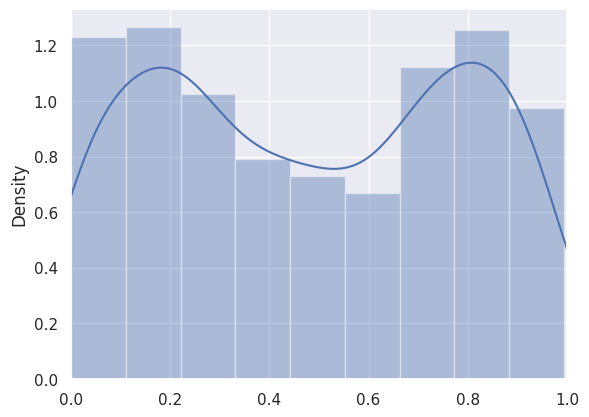

In [79]:
# xgb_clf.load_model('./model/XGB_Feature91.model')
pred = xgb_clf.predict(test_GB)
proba = xgb_clf.predict_proba(test_GB)[:, 1]
print(f'{sum(pred)} / {len(pred)}') ; print(min(proba), max(proba))
sns.distplot(proba) ; plt.xlim([0, 1]) ; plt.show()

In [80]:
# SAVE OUTPUT
output_dir = 'submit/'
write_path = os.path.join(output_dir, 'XGBCLF_Feature91_NewHPO.csv')
if not os.path.exists(output_dir) :
    os.makedirs(output_dir)
with open(write_path, 'w', encoding = 'utf8') as w :
    print('Writing Prediction : {}'.format(write_path))
    w.write('id,prediction\n')
    for id, p in enumerate(proba) :
        w.write('{},{}\n'.format(id, p))

Writing Prediction : submit/XGBCLF_Feature91_NewHPO.csv
